In [10]:
from mxlpy import Simulator, make_protocol
import itertools as it
from typing import cast, Literal
from tqdm.notebook import tqdm
from scipy.signal import find_peaks, peak_prominences
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import pandas as pd
import sqlite3
from pathlib import Path

here = Path("").absolute()
print(here)

/home/elouencorvestnew/Documents/GreenSloth/models/Matuszynska2016/paper_figures


In [11]:
%%capture
cd .. # noqa

In [12]:
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from cycler import cycler
from mxlpy import Simulator, plot, make_protocol, Model, scan, mca, cartesian_product
import pandas as pd
import numpy as np

sys.path.append(os.path.abspath('..'))

from model import Matuszynska2016

here = Path("").absolute()

def save_fig(fig_num: str) -> Path:
    here = Path("").absolute()
    name = "Matuszynska2016"
    plt.savefig(here / f"{name.lower()}_fig{fig_num}.svg", format="svg", bbox_inches="tight")

In [13]:
Matuszynska2016().get_stoichiometries()

,v_PSII,v_PQ,v_ATPsynth,v_Leak,v_ATPcons,v_ATPact,v_Xcyc,v_PsbSP
PQH_2,1.00,-1.00,0.000000,0.00,0.0,0.0,0.0,0.0
H_lu,0.02,0.04,-0.046667,-0.01,0.0,0.0,0.0,0.0
ATP_st,0.00,0.00,1.000000,0.00,-1.0,0.0,0.0,0.0
ATPase_ac,0.00,0.00,0.000000,0.00,0.0,1.0,0.0,0.0
Vx,0.00,0.00,0.000000,0.00,0.0,0.0,-1.0,0.0
psbS,0.00,0.00,0.000000,0.00,0.0,0.0,0.0,-1.0


## Helper Functions



In [14]:
def cpfd(species, PFD):
    """
    converts the given light intensity into internal activation rate
    calibrated for 3 light intensities for two species
    """
    if species == 'Arabidopsis':
        light =  0.0005833 * PFD**2 + 0.2667 * PFD + 187.5
    elif species == 'Pothos':
        light = 0.0004167 * PFD**2 + 0.3333 * PFD + 862.5

    return light

In [15]:
def create_pam_protocol(
    phase_intervals: list,
    light_phases: list,
    SP_pfd = 5000,
    SP_duration = 0.8,
):
    protocol = []
    for i in range(len(phase_intervals)):
        for relax_time in phase_intervals[i]:
            protocol.append((SP_duration, {"pfd": SP_pfd}))
            protocol.append((relax_time - SP_duration, {"pfd": light_phases[i]}))

    return protocol

def phase_intervals_linear(
    phase_duration,
    step,
    first_interval = 0,
    num_steps = None,
    last_intervall = None
):
    phase = []
    accumulated_time = 0
    current_time = first_interval
    
    while accumulated_time < phase_duration and (num_steps is None or len(phase) < num_steps):
        accumulated_time += current_time
        if accumulated_time < phase_duration:
            phase.append(current_time)
        current_time = step * len(phase) + first_interval
        
    if last_intervall is not None:
        phase.append(phase_duration - last_intervall - sum(phase))
        if last_intervall != 0:
            phase.append(last_intervall)
    
    return phase


In [16]:
def npq(
    s: Simulator,
    fluo_key: str = 'Fluo',
    peak_distance: float = 30
):
    
    fluo_results = s.get_full_concs()[fluo_key] / max(s.get_full_concs()[fluo_key])
    
    # Find the Flourescence peaks (Fmaxs)
    peaks, _ = find_peaks(fluo_results, distance=peak_distance, height=0)
    
    # Get time at peaks
    time = s.get_full_concs().iloc[peaks].index
    
    # Get Fm
    Fm = fluo_results.iloc[peaks].values
    
    # Calculate NPQ
    NPQ = (Fm[0] - Fm) / Fm
    
    # Find the minima around the peaks
    prominences, prominences_left, prominences_right = peak_prominences(
                (fluo_results), peaks
            )  
    
    # Fo is always the minima before the peak
    Fo = fluo_results.iloc[prominences_left].values
    
    # Maximum quantum yield of PSII (Fv/Fm)
    QY_PSII = (Fm - Fo) / Fm
    
    return time, Fm, NPQ, Fo, QY_PSII

## Experimental Data

In [17]:
def prepare_experimental_data(
    data: pd.DataFrame,
    species: Literal["Arabidopsis", "Pothos"],
    pfds: list,
    darkdurations: list
):
    df = data[data.Specie == species].copy()
    
    res = []
    for lightintensity, darkduration in zip(pfds, darkdurations):
        df_li = df[df.LightIntensity == lightintensity].copy()
        df_li_dd = df_li[df_li.DarkDuration == darkduration].copy()
        df_li_dd['Time'] = pd.to_timedelta(df_li_dd['Time'])
        
        replicates = []
        
        for replic in [1, 2, 3]:
            df_li_dd_replic = df_li_dd[df_li_dd['Replicate'] == replic].copy()
            
            df_li_dd_replic['Timedelta'] = (df_li_dd_replic['Time'] - df_li_dd_replic['Time'].iloc[0]).apply(lambda x: x.total_seconds())
            df_li_dd_replic['Fm_rel'] = (df_li_dd_replic['Fm'] / df_li_dd_replic['Fm'].iloc[0])
            df_li_dd_replic['Ft_rel'] = (df_li_dd_replic['Ft'] / df_li_dd_replic['Fm'].iloc[0])
            df_li_dd_replic['Yield'] = df_li_dd_replic['Yield']
            
            replicates.append(df_li_dd_replic)

        df_li_dd = pd.concat(replicates)
        df_li_dd_mean = df_li_dd[['Timedelta', 'Fm_rel', 'Ft_rel', 'Yield', 'ExpId']].groupby('ExpId').agg({'Timedelta': 'mean', 'Fm_rel': ['mean', 'std'], 'Ft_rel': ['mean', 'std'], 'Yield': 'mean'})
        df_li_dd_mean.columns = ['Timedelta_mean','Fm_rel_mean', 'Fm_rel_std','Ft_rel_mean', 'Ft_rel_std', 'Yield_mean']
        
        res.append(df_li_dd_mean)

    return res

In [18]:
cnx = sqlite3.connect('paper_figures/paperdata_new.db')

cur = cnx.cursor()

# reading all table names
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]

df = pd.read_sql_query("select * from LIGHTMEMORY", cnx)
print(df.columns)
columns_to_keep = ['ExpId', 'Fm', 'Specie', 'LightIntensity', 'DarkDuration', 'Time', 'Replicate', 'Ft', 'Yield']
df = df.drop(columns=[i for i in df.columns if i not in columns_to_keep])

fig4_data = prepare_experimental_data(df, "Arabidopsis", [100, 300, 900], [15, 30, 60])
fig6_data = prepare_experimental_data(df, "Pothos", [100], [15])

OperationalError: unable to open database file

## Figure 4

In [19]:
phase_1 = [30]
phase_two = phase_intervals_linear(14*60, 20, 30)
phase_four = phase_intervals_linear(5*60, 20, 30, last_intervall=0)

In [21]:
phase_three = phase_intervals_linear(15*60, 20, 30, num_steps=5, last_intervall=30)

pam_protocol1 = create_pam_protocol(
    [
        phase_1,
        phase_two,
        phase_three,
        phase_four
    ],
    [
        0,
        cpfd('Arabidopsis', 100),
        0,
        cpfd('Arabidopsis', 100)
    ]
)

pam_protocol1 = make_protocol(pam_protocol1)

s1 = Simulator(Matuszynska2016())
s1.simulate_protocol(pam_protocol1, time_points_per_step=100);

In [23]:
phase_three = phase_intervals_linear(30*60, 20, 30, num_steps=5, last_intervall=30)

pam_protocol2 = create_pam_protocol(
    [
        phase_1,
        phase_two,
        phase_three,
        phase_four
    ],
    [
        0,
        cpfd('Arabidopsis', 300),
        0,
        cpfd('Arabidopsis', 300)
    ]
)

pam_protocol2 = make_protocol(pam_protocol2)

s2 = Simulator(Matuszynska2016())
s2.simulate_protocol(pam_protocol2, time_points_per_step=100);

In [24]:
phase_three = phase_intervals_linear(60*60, 20, 30, num_steps=5, last_intervall=30)

pam_protocol3 = create_pam_protocol(
    [
        phase_1,
        phase_two,
        phase_three,
        phase_four
    ],
    [
        0,
        cpfd('Arabidopsis', 900),
        0,
        cpfd('Arabidopsis', 900)
    ]
)

pam_protocol3 = make_protocol(pam_protocol3)

s3 = Simulator(Matuszynska2016())
s3.simulate_protocol(pam_protocol3, time_points_per_step=1000);

NameError: name 'exp_data' is not defined

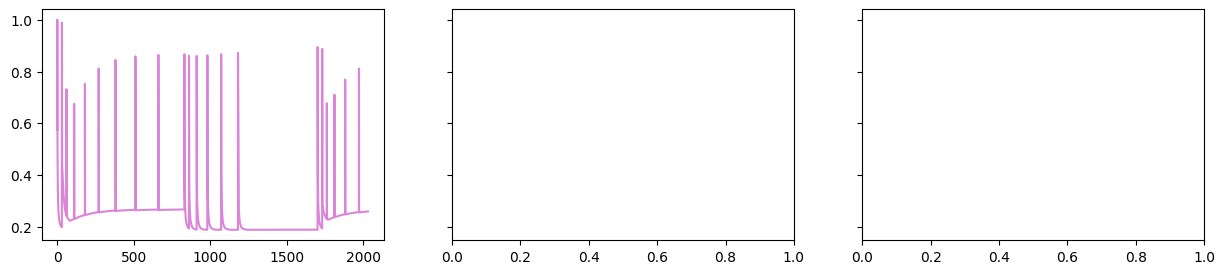

In [ ]:
res = [
    {'sim': s1, 'protocol': pam_protocol1, 'light': 100, 'duration': 15},
    {'sim': s2, 'protocol': pam_protocol2, 'light': 300, 'duration': 30},
    {'sim': s3, 'protocol': pam_protocol3, 'light': 900, 'duration': 60},
]

fig, axs = plt.subplots(ncols=3, figsize=(15, 3), sharey=True)

box_height = 0.15
border_width = 0.01

for i in range(len(axs)):
    ax = axs[i]
    c = res[i]['sim'].get_result().unwrap_or_err().get_combined()
    pam_protocol = res[i]['protocol']
    # exp_data = fig4_data[i]
    
    pam_ptrc_cleaned = pam_protocol[pam_protocol['pfd'] != 5000]
    pam_ptrc_peaks = pam_protocol[pam_protocol['pfd'] == 5000]
    peaks_times = pd.Series(pam_ptrc_peaks.index).apply(lambda x: x.total_seconds())

    ax.plot(c["Fluo"] / max(c["Fluo"]), color="#db85d8", label="Simulated trace")
    ax.errorbar(peaks_times, exp_data['Fm_rel_mean'][:-1], yerr=exp_data['Fm_rel_std'][:-1], marker="^", color="black", linestyle='None', elinewidth=0.5, capsize=2.5, label=r"$\mathrm{F_M^'}$ measured", markersize=3.5)
    ax.errorbar(peaks_times, exp_data['Ft_rel_mean'][:-1], yerr=exp_data['Ft_rel_std'][:-1], marker="^", color="#0071ad", linestyle='None', elinewidth=0.5, capsize=2.5, label=r"$\mathrm{F_S}$ measured", markersize=3.5)
    
    ax.set_xlim(-60, c.index[-1])
    ax.set_ylim(0, 1.11 * (exp_data['Fm_rel_mean'].max() + exp_data['Fm_rel_std'].iloc[exp_data['Fm_rel_mean'].idxmax()]))

    timechanges = []
    
    prior = ax.get_xlim()[0] 
    
    for t_end, val in pam_ptrc_cleaned['pfd'].items():
        t_end = t_end.total_seconds()
        if val == 0:
            color="black"
        else:
            color="white"
        
        if len(timechanges) > 0 and timechanges[-1][0] == color:
            timechanges[-1][-1] = t_end
        else:
            timechanges.append([color, prior, t_end])
            
        prior = t_end
    
    for bar in timechanges:
        box = ax.add_patch(Rectangle(
            (bar[1], ax.get_ylim()[-1]),
            width=abs(bar[1] - bar[2]),
            height=box_height,
            facecolor = bar[0],
            edgecolor='black',
            clip_on=False
        ))
    
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/60:.1f}"))
    ax.set_xticks([i[-1] for i in timechanges])
    ax.set_xlabel('time [min]')
    
    ycoord_text = box.xy[1] + box.get_height() / 2
    xcoord_light = timechanges[1][1] + abs(timechanges[1][1] - timechanges[1][2]) / 2
    
    light_text = f'{res[i]['light']}'
    if res[i]['light'] == 100:
        light_text += r' $\mu E m^{{-2}} s^{{-1}}$'
        
    xcoord_dark = timechanges[2][1] + abs(timechanges[2][1] - timechanges[2][2]) / 2
    
    ax.text(xcoord_light, ycoord_text, light_text, ha="center", va="center", weight='bold')
    ax.text(xcoord_dark, ycoord_text, f"{res[i]['duration']} min", ha="center", va="center", weight='bold', color="white")

axs[0].set(
    ylabel=r"Fluorescence ($\mathrm{F_M^'}$ / $\mathrm{F_M}$)",
)

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles, labels, ncols=3, loc='lower center', shadow=True, framealpha=1, edgecolor='black')

plt.tight_layout()
    plt.subplots_adjust(bottom=0.3)
plt.savefig(here + "/Matuszynska_fig4.svg", dpi=300)
plt.show()

## Figure 5

In [ ]:
def simulate_pam_different_lights(
    LP_pfds: list = [100, 300, 900],
    species: str = 'Arabidopsis',
    phases = [30, 14*60 - 30, 16*60, 5*60]
):
    
    res = []
    
    for pfd in LP_pfds:
        cpfd_val = cpfd(species, pfd)

        s = Simulator(Matuszynska2016())
        
        for time, light in zip(it.accumulate(phases), [0, cpfd_val] * len(phases)):
            s.update_parameter('pfd', light)
            s.simulate(time)
        res.append({
            'sim': s,
            'protocol': [(time, light) for time, light in zip(phases, [0, cpfd_val] * len(phases))],
            'light': pfd
        })
        
    return res

In [ ]:
fig5_sims = simulate_pam_different_lights()

In [ ]:
fig5_pH_lu_steady = []
fig5_Q_steady = []
fig5_timepoints_steady = []

s = Simulator(Matuszynska2016())
for i in tqdm(range(0, 1000, 10), "Simulating Steady State"):
    s.update_parameter('pfd', cpfd('Arabidopsis', i))
    s.simulate_to_steady_state()
    fig5_timepoints_steady.append(i)
    fig5_pH_lu_steady.append(s.get_full_results()['pH_lu'].iloc[-1])
    fig5_Q_steady.append(s.get_full_results()['Q'].iloc[-1])

Simulating Steady State:   0%|          | 0/100 [00:00<?, ?it/s]

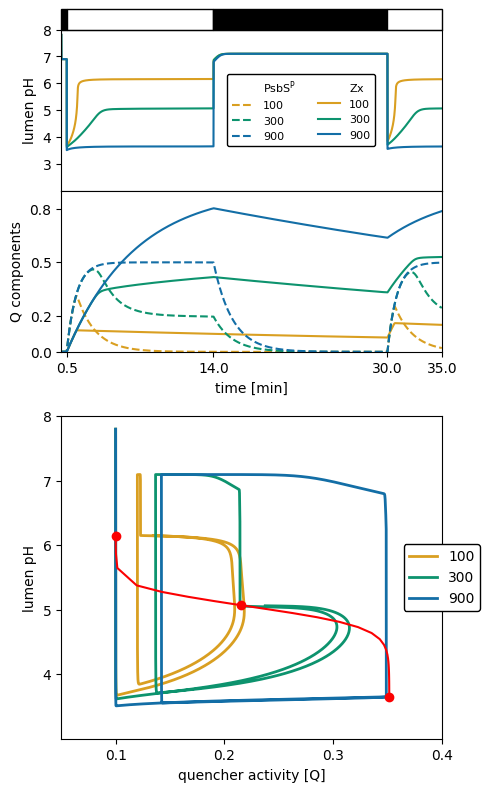

In [ ]:
fig = plt.figure(figsize=(5, 8))

gs = gridspec.GridSpec(4, 1, height_ratios=[1, 1, 0.4, 2], hspace=0)

ax_A_1 = fig.add_subplot(gs[0])
ax_A_1.set_ylim(2, 8)
ax_A_1.set_yticks([i for i in range(3,9)])
ax_A_1.set_ylabel("lumen pH")
ax_A_1.get_xaxis().set_visible(False)

ax_A_2 = fig.add_subplot(gs[1], sharex=ax_A_1)
ax_A_2.set_ylim(0, 0.9)
ax_A_2.set_yticks([0, 0.2, 0.5, 0.8])
ax_A_2.set_ylabel("Q components")
ax_A_2.set_xlim(0, fig5_sims[0]['sim'].get_full_results().index[-1])
ax_A_2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/60:.1f}"))
ax_A_2.set_xticks(list(it.accumulate([time for time, light in fig5_sims[0]['protocol']])))
ax_A_2.set_xlabel('time [min]')

ax_B = fig.add_subplot(gs[3])
ax_B.set_ylim(3, 8)
ax_B.set_yticks([i for i in range(4,9)])
ax_B.set_ylabel("lumen pH")
ax_B.set_xlim(0.05, 0.4)
ax_B.set_xticks([0.1, 0.2, 0.3, 0.4])
ax_B.set_xlabel("quencher activity [Q]")

ax_B.plot(fig5_Q_steady, fig5_pH_lu_steady, color="#fb0102", zorder=9)

for i in [100, 300, 900]:
    ax_B.scatter(fig5_Q_steady[fig5_timepoints_steady.index(i)], fig5_pH_lu_steady[fig5_timepoints_steady.index(i)], color="#fb0102", zorder=10)

colors = [
    "#d99f21",
    "#0d936e",
    "#136ea6"
]

symbols = [
    'x',
    "o",
    "s"
]

for sim in fig5_sims:
    res = sim['sim'].get_full_results()
    light = sim['light']
    color = colors[fig5_sims.index(sim)]
    symbol = symbols[fig5_sims.index(sim)]
    
    for ax in [ax_A_1, ax_A_2]:
        ax.plot(res["pH_lu"], color=color)
        ax.plot(res["PsbSP"], color=color, linestyle='--', label=light)
        ax.plot(res["Zx"], color=color, label=light)
        
    ax_B.plot(res["Q"], res["pH_lu"], color=color, markersize=2, lw=2, label=light)

prior = 0
for time, light in fig5_sims[0]['protocol']:
    if light > 0:
        box_color = 'white'
    else:
        box_color = 'black'
    
    ax_A_1.add_patch(Rectangle(
            (prior, ax_A_1.get_ylim()[-1]),
            width=time,
            height=abs(ax_A_1.get_ylim()[0] - ax_A_1.get_ylim()[1]) * 1/8,
            facecolor = box_color,
            edgecolor = 'black',
            clip_on=False
        ))
    prior += time

handles_labels = ax_A_1.get_legend_handles_labels()

handles_col1 = [Line2D([], [], color="none")]
handles_col2 = [Line2D([], [], color="none")]

labels_col1 = [r"$\mathrm{PsbS^P}$"]
labels_col2 = [r"$\mathrm{Zx}$"]

for i in range(len(handles_labels[0])):
    if i % 2 == 0:
        handles_col1.append(handles_labels[0][i])
        labels_col1.append(handles_labels[1][i])
    else:
        handles_col2.append(handles_labels[0][i])
        labels_col2.append(handles_labels[1][i])

ax_A_1.legend(list(it.chain(handles_col1, handles_col2)), list(it.chain(labels_col1, labels_col2)), ncols=2, prop={"size": 8}, framealpha=1, edgecolor="black", loc='center', bbox_to_anchor=(0.63,0.5))

ax_B.legend(loc='center', bbox_to_anchor=(1,0.5), edgecolor='black', framealpha=1)

plt.tight_layout()
plt.savefig(here + "/Matuszynska_fig5.svg", dpi=300)
plt.show()

## Figure 6

In [ ]:
pothos = Matuszynska2016()

# Increased gamma_2 coefficient from 0.6 to 1
pothos.update_parameter('gamma_2', 1)
pothos.update_parameter('pfd', 0)

phase_one = [30]
phase_two = phase_intervals_linear(14*60, 20, 30)
phase_three = phase_intervals_linear(15*60, 20, 30, num_steps=5, last_intervall=30)
phase_four = phase_intervals_linear(5*60, 20, 30, last_intervall=0)

pam_protocol_fig6 = create_pam_protocol(
    [
        phase_one,
        phase_two,
        phase_three,
        phase_four
    ],
    [
        0,
        cpfd('Pothos', 100),
        0,
        cpfd('Pothos', 100)
    ]
)

pam_protocol_fig6 = make_protocol(pam_protocol_fig6)

s_pothos = Simulator(pothos)
s_pothos.simulate_over_protocol(pam_protocol_fig6, time_points_per_step=1000);

In [ ]:
peaktimes, Fm, NPQ, Fo, QY_PSII = npq(
    s = s_pothos,
    peak_distance=250
)

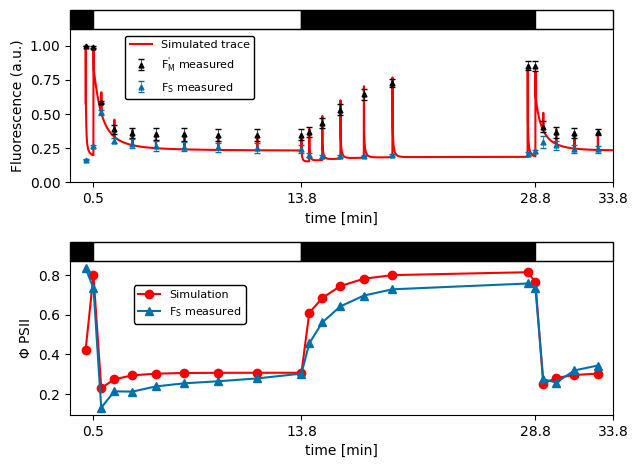

In [ ]:

fig6, axs = plt.subplots(nrows=2)

res = s_pothos.get_full_results()

axs[0].set_ylim(0, 1.11 * (fig6_data[0]['Fm_rel_mean'].max() + exp_data['Fm_rel_std'].iloc[fig6_data[0]['Fm_rel_mean'].idxmax()]))
axs[0].set_ylabel("Fluorescence (a.u.)")

axs[0].plot(res['Fluo'] / max(res['Fluo']), color="#fa0100", label="Simulated trace")
axs[0].errorbar(peaktimes, fig6_data[0]['Fm_rel_mean'][:-1], yerr=fig6_data[0]['Fm_rel_std'][:-1], marker="^", color="black", linestyle='None', elinewidth=0.5, capsize=2.5, label=r"$\mathrm{F_M^'}$ measured", markersize=3.5)
axs[0].errorbar(peaktimes, fig6_data[0]['Ft_rel_mean'][:-1], yerr=fig6_data[0]['Ft_rel_std'][:-1], marker="^", color="#0071ad", linestyle='None', elinewidth=0.5, capsize=2.5, label=r"$\mathrm{F_S}$ measured", markersize=3.5)

axs[1].set_ylabel(r"$\Phi$ PSII")

axs[1].plot(peaktimes, QY_PSII, color="#fa0100", marker='o', label="Simulation")
axs[1].plot(peaktimes, fig6_data[0]['Yield_mean'][:-1], marker="^", color="#0071ad", label=r"$\mathrm{F_S}$ measured")

pam_protocol_fig6_cleaned = pam_protocol_fig6[pam_protocol_fig6['pfd'] != 5000]

for ax in axs:
    box_height = abs(ax.get_ylim()[0] - ax.get_ylim()[1]) * 1/8
    
    ax.set_xlim(-60, res.index[-1])
    ax.set_xlabel('time [min]')
    
    timechanges = []
    
    prior = ax.get_xlim()[0] 
    
    for t_end, val in pam_protocol_fig6_cleaned['pfd'].items():
        t_end = t_end.total_seconds()
        if val == 0:
            color="black"
        else:
            color="white"
        
        if len(timechanges) > 0 and timechanges[-1][0] == color:
            timechanges[-1][-1] = t_end
        else:
            timechanges.append([color, prior, t_end])
            
        prior = t_end
    
    for bar in timechanges:
        box = ax.add_patch(Rectangle(
            (bar[1], ax.get_ylim()[-1]),
            width=abs(bar[1] - bar[2]),
            height=box_height,
            facecolor = bar[0],
            edgecolor='black',
            clip_on=False
        ))
    
    legend_xcoord = abs(timechanges[1][1] - timechanges[2][1]) / 2
    
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x/60:.1f}"))
    ax.set_xticks([i[-1] for i in timechanges])
    
    ax.legend(loc='center', bbox_to_anchor=(legend_xcoord, ax.get_ylim()[-1]* (3/4)), framealpha=1, edgecolor='black', bbox_transform=ax.transData, prop={"size": 8})

plt.tight_layout()
plt.savefig(here + "/Matuszynska_fig6.svg", dpi=300)
plt.show()